# Ethereum Price Change Direction Forecasting
In this project, we aim at forecasting the direction of the price change of Ethereum. We extract the historical data (daily values) of ETH prices from the Yahoo Finance repository, preprocess the data, and fit a simple logistic regression model over the data. In the preprocessing stage, we extract the direction of the ETH price change (increase, decrease, or fixed) on each day. So, we are dealing with a classification problem. We also implement a window generation function to be able to forecast the next day's price change direction based on the previously recorded data.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.metrics as met
import sklearn.dummy as dm

np.random.seed(0)

### 1. Data Extraction
Extracting the historical data for daily prices of ETH:

In [2]:
Ticker = 'ETH-USD'
Interval = '1d'
Period = 'max'

data_full = yf.download(tickers=Ticker, interval=Interval, period=Period)

[*********************100%***********************]  1 of 1 completed


In [3]:
data_full.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992


In [4]:
data_full.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-03,1633.051270,1678.098267,1595.634521,1618.874512,1618.874512,16786218830
2022-08-04,1618.886719,1658.511597,1585.326538,1608.205811,1608.205811,14467440626
2022-08-05,1606.497070,1663.916504,1606.497070,1656.268677,1656.268677,15211467776


### 2. Data Preprocessing

Calculating the ETH price change rate (PCR) in percentage on each day:

In [5]:
data_full['PCR'] = 100 * (data_full['Close'] - data_full['Open'])/data_full['Open']

Text(0, 0.5, 'ETH PCR (%)')

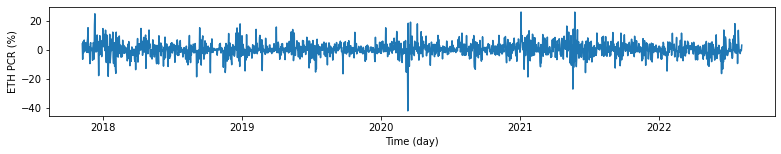

In [6]:
# plotting the line graph of PCR
plt.figure(figsize=(13,2))
plt.plot(data_full['PCR'])
plt.xlabel('Time (day)')
plt.ylabel('ETH PCR (%)')

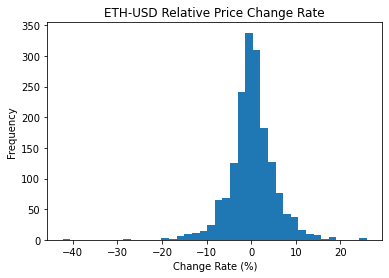

In [7]:
# plotting the histogram graph of PCR
plt.hist(data_full['PCR'], bins=40)
plt.title('ETH-USD Relative Price Change Rate')
plt.xlabel('Change Rate (%)')
plt.ylabel('Frequency')
plt.show()

It has a normal distribution. We use interquartile range to bound the PCR values between the first and the third quartiles. 

In [8]:
quartile_1 = data_full['PCR'].quantile(0.25)
quartile_3 = data_full['PCR'].quantile(0.75)
IQR = quartile_3 - quartile_1 # inter quartile range
lower_bound = quartile_1 - 2 * IQR
upper_bound = quartile_3 + 2 * IQR

# applying to the PCR data
data_full['PCR'] = data_full['PCR'].clip(lower=lower_bound, upper=upper_bound)

we plot the histogram graph again:

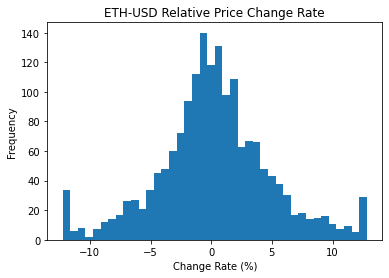

In [9]:
# plotting the histogram graph of PCR
plt.hist(data_full['PCR'], bins=40)
plt.title('ETH-USD Relative Price Change Rate')
plt.xlabel('Change Rate (%)')
plt.ylabel('Frequency')
plt.show()

We can also use other outlier detection and removal methods so that we do not have the current data accumulation at both the lower and upper bounds, as can be seen in the above graph.

We generate data windows using a Lag function which is defined as follows:

In [10]:
def Lag(data, input_width):
    window_number = data.size - input_width
    X = np.zeros((window_number, input_width))
    Y = np.zeros((window_number, 1))
    for i in range(window_number):
        X[i,:] = data[i:i+input_width] # input
        Y[i,0] = data[i+input_width] # target
    return X, Y

In [11]:
X0, Y0 = Lag(data=data_full['PCR'], input_width=30)
X0.shape, Y0.shape

((1701, 30), (1701, 1))

We split the data into train and test sets as follows:

In [12]:
train_split = 0.8
split_num = int(train_split * data_full['PCR'].size)

X0_train = X0[:split_num]
Y0_train = Y0[:split_num]
X0_test = X0[split_num:]
Y0_test = Y0[split_num:]

(X0_train.shape, Y0_train.shape) , (X0_test.shape, Y0_test.shape)

(((1384, 30), (1384, 1)), ((317, 30), (317, 1)))

We standardize the data based on the training set. We do not scale the target values since they will be converted into labels to show the direction of the price change.

In [13]:
scale_X = pp.StandardScaler().fit(X0_train)
X0_train_std = scale_X.transform(X0_train)
X0_test_std = scale_X.transform(X0_test)

Since we are going to forecast the direction of the price change, we need to define a discretizer function to assign 3 labels to the data points based on a given threshold. This function is defined as follows:

In [14]:
def Discretizer(data, threshold):
    output = np.zeros((len(data), 1))
    for i in range(len(data)):
        if data[i] < -threshold: # decrease
            output[i,0] = 0
        elif data[i] > +threshold: # increase
            output[i,0] = 2
        else:
            output[i,0] = 1 # fixed
    return output

In [15]:
TH = 2 # price changes rates (PCR) between -2% and 2% are considered as 0 (no change)
Y0_train_label = Discretizer(Y0_train, TH)
Y0_test_label = Discretizer(Y0_test, TH)

In [16]:
print(Y0_train_label.shape, Y0_test_label.shape)

(1384, 1) (317, 1)


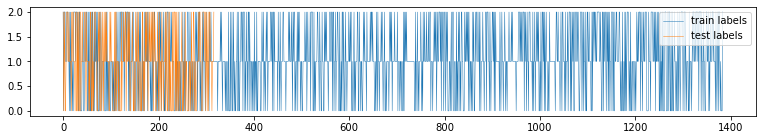

In [17]:
plt.figure(figsize=(13,2))
plt.plot(pd.DataFrame(Y0_train_label), linewidth=0.5, label='train labels')
plt.plot(pd.DataFrame(Y0_test_label), linewidth=0.5, label='test labels')
plt.legend()
plt.show()

## 3. Model Training

We use a logistic regression model to train our price change direction forecaster.

In [18]:
model_LR = lm.LogisticRegression()
model_LR.fit(X0_train_std, Y0_train_label)

c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [19]:
prediction_train = model_LR.predict(X0_train_std)
prediction_test = model_LR.predict(X0_test_std)

Evaluating the performance of the model 

In [20]:
performance_train = met.classification_report(Y0_train_label, prediction_train)
performance_test = met.classification_report(Y0_test_label, prediction_test)

print(f'Performance of the logistic regression model on the training set:\n{performance_train}')
print('-'*60)
print(f'Performance of the logistic regression model on the test set:\n{performance_test}')

Performance of the logistic regression model on the training set:
              precision    recall  f1-score   support

         0.0       0.41      0.08      0.14       365
         1.0       0.47      0.84      0.60       603
         2.0       0.43      0.23      0.30       416

    accuracy                           0.46      1384
   macro avg       0.43      0.39      0.35      1384
weighted avg       0.44      0.46      0.39      1384

------------------------------------------------------------
Performance of the logistic regression model on the test set:
              precision    recall  f1-score   support

         0.0       0.25      0.04      0.07        98
         1.0       0.39      0.83      0.53       128
         2.0       0.16      0.05      0.08        91

    accuracy                           0.36       317
   macro avg       0.27      0.31      0.23       317
weighted avg       0.28      0.36      0.26       317



As can be seen in the above results, the performance of the model is not satisfactory. Part of this problem comes from the fact that the dataset is unbalanced. In order to solve this issue, we define separate weights for each class considering the number of data points with the labels of each class in the training set.

![Weights Calculation](weight_calculation.png)

In [21]:
nClass = 3 # number of classes
train_size = Y0_train_label.size

label_number = {i : Y0_train_label[Y0_train_label == i].size for i in range(nClass)}
weights = {i : (train_size - label_number[i])/((nClass - 1) * train_size) for i in range(nClass)}

In [22]:
print(label_number)
print(weights)

{0: 365, 1: 603, 2: 416}
{0: 0.368135838150289, 1: 0.28215317919075145, 2: 0.34971098265895956}


We now train a new model using the calculated weights: 

In [23]:
model_LR = lm.LogisticRegression(class_weight=weights)
model_LR.fit(X0_train_std, Y0_train_label)


c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 0.368135838150289, 1: 0.28215317919075145,
                                 2: 0.34971098265895956})

In [24]:
prediction_train = model_LR.predict(X0_train_std)
prediction_test = model_LR.predict(X0_test_std)

performance_train = met.classification_report(Y0_train_label, prediction_train)
performance_test = met.classification_report(Y0_test_label, prediction_test)

print(f'Performance of the logistic regression model on the training set:\n{performance_train}')
print('-'*60)
print(f'Performance of the logistic regression model on the test set:\n{performance_test}')

Performance of the logistic regression model on the training set:
              precision    recall  f1-score   support

         0.0       0.40      0.25      0.31       365
         1.0       0.50      0.65      0.57       603
         2.0       0.41      0.37      0.39       416

    accuracy                           0.46      1384
   macro avg       0.44      0.42      0.42      1384
weighted avg       0.45      0.46      0.45      1384

------------------------------------------------------------
Performance of the logistic regression model on the test set:
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.19        98
         1.0       0.36      0.56      0.44       128
         2.0       0.18      0.13      0.15        91

    accuracy                           0.31       317
   macro avg       0.27      0.28      0.26       317
weighted avg       0.28      0.31      0.28       317



As can be seen in the above results, the performance of the model has improved after using the class weights.
However, the performance of a logistic regression model is not that much good to be considered reliable. Although, we can compare the performance of this model with a dummy classifier to better understand the performance of the model.

In [25]:
model_dummy = dm.DummyClassifier(strategy='most_frequent')
model_dummy.fit(X0_train_std, Y0_train_label)

prediction_train = model_dummy.predict(X0_train_std)
prediction_test = model_dummy.predict(X0_test_std)

performance_train = met.classification_report(Y0_train_label, prediction_train)
performance_test = met.classification_report(Y0_test_label, prediction_test)

print(f'Performance of the logistic regression model on the training set:\n{performance_train}')
print('-'*60)
print(f'Performance of the logistic regression model on the test set:\n{performance_test}')


Performance of the logistic regression model on the training set:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       365
         1.0       0.44      1.00      0.61       603
         2.0       0.00      0.00      0.00       416

    accuracy                           0.44      1384
   macro avg       0.15      0.33      0.20      1384
weighted avg       0.19      0.44      0.26      1384

------------------------------------------------------------
Performance of the logistic regression model on the test set:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        98
         1.0       0.40      1.00      0.58       128
         2.0       0.00      0.00      0.00        91

    accuracy                           0.40       317
   macro avg       0.13      0.33      0.19       317
weighted avg       0.16      0.40      0.23       317



c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIO\.conda\envs\envtf\lib\si

It can be seen that the performance of the logistic regression is much better than a dummy classifier.

------
#### END